In [2]:
# Imports sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, max_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold

# Imports python
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading data

In [3]:
# load the data
train_data = pd.read_csv('../CHEMBL239_dataset_train.csv')
test_data = pd.read_csv('../CHEMBL239_dataset_test.csv')

# Get x and y values
y_train = train_data.loc[:, 'exp_mean']
y_test = test_data.loc[:, 'exp_mean']
X_train = train_data.loc[:, 'Bit 1' : 'Bit 1024']
X_test = test_data.loc[:, 'Bit 1' : 'Bit 1024']

training_dataset = X_train, y_train
testing_dataset = X_test, y_test

# Models

In [164]:
# K - Nearest Neighbors Model
def KNN_model(train_data, test_data):
    
    # Create training and testing data
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    # Lists for the visualize function
    list_y_pred = []
    list_y_actual = []
    list_y_diff = []
    
    # Metrics for all number of neighbors
    metrics_KNN_all = []
    
    # Set the parameters to check with GridSearch
    param = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

    # GridSearch on KNN
    knn_model = GridSearchCV(KNeighborsRegressor(), param, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)
    
    # Store the best n_neighbors parameter
    best_param = knn_model.best_params_['n_neighbors']
    
    # Print the best n_neighbors parameter
    print('The best value for the n_neighbors parameter in the KNN model is:', best_param)
    
    # TODO look if this is good cross validation or that it also needed for best knn model
    #Make KNN with best n_neighbors parameter
    best_knn_model = KNeighborsRegressor(n_neighbors=best_param, n_jobs=-1).fit(X_train, y_train)

    # Make prediction
    y_pred_knn=best_knn_model.predict(X_test)
        
    # Compute the metrics and store it in the total list of metrics
    metrics_KNN = compute_metric(y_test, y_pred_knn)
            
    for item in y_pred_knn:
        list_y_pred.append(item)

    for item in y_test:
        list_y_actual.append(item)

    for index in range(0, len(y_test)):
        list_y_diff.append(list_y_pred[index] - list_y_actual[index])
    
    # Create plots of the data
    visualize('knn', list_y_actual, list_y_pred, list_y_diff)
        
    return metrics_KNN


# Support Vector Regression Model
def SVR_model(train_data, test_data):
    
    # Create training and testing data
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    # Set the parameters to check with GridSearch
    param = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

    # GridSearch on SVR
    svr_model = GridSearchCV(SVR(), param, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)
    
    # Store the best kernel parameter
    best_param = svr_model.best_params_['kernel']
    
    # Print the best kernel parameter
    print('The best value for the kernel parameter in the SVR model is:', best_param)

    # Make SVR with best kernel parameter
    best_svr_model = SVR(kernel = best_param).fit(X_train, y_train)

    #Mmake prediction
    y_pred_svr = best_svr_model.predict(X_test)
    
    metrics_SVR = compute_metric(y_test, y_pred_svr)

    list_y_pred = []
    list_y_actual = []
    list_y_diff = []
    
    for item in y_pred_svr:
        list_y_pred.append(item)

    for item in y_test:
        list_y_actual.append(item)

    for index in range(0, len(y_test)):
        list_y_diff.append(list_y_pred[index] - list_y_actual[index])
        
    # Create plots of the data
    visualize('svr', list_y_actual, list_y_pred, list_y_diff)
        
    return metrics_SVR

    
# Random Forest model 
def RF_model(train_data, test_data):
    
    # Create training and testing data
    x_train, y_train = train_data
    x_test, y_test = test_data
    
    # Make lists for metrics
    mean_squared_error_score = []
    variance_score = []
    max_error_score = []
    r2_value = []
    rmsep = []
    
    list_y_pred = []
    list_y_actual = []
    list_y_diff = []
    
    # Set the parameters to check with GridSearch
    param = {'n_estimators': [50, 100, 500, 1000]}

    # GridSearch on RandomForestRegressor
    rf_model = GridSearchCV(RandomForestRegressor(), param, cv=5, return_train_score=True, n_jobs=-1, verbose=1).fit(X_train,y_train)
    
    # Store the best n_estimator parameter
    best_param = rf_model.best_params_['n_estimators']
    
    # Print the best n_estimator parameter
    print('The best value for the n_estimator parameter in the RF model is:', best_param)

    # Make randomforest with best value for n_estimator
    best_rf_model = RandomForestRegressor(n_estimators = best_param).fit(X_train,y_train)

    # Make prediction
    y_pred_rf=best_rf_model.predict(X_test)

    # Compute regression metrics
    metrics_RF = compute_metric(y_test, y_pred_rf)
    
    for item in y_pred_rf:
        list_y_pred.append(item)

    for item in y_test:
        list_y_actual.append(item)

    for index in range(0, len(y_test)):
        list_y_diff.append(list_y_pred[index] - list_y_actual[index])
    
    # Create plots of the data
    visualize('rf', list_y_actual, list_y_pred, list_y_diff)
        
    return metrics_RF

# Metrics

In [169]:
# Compute the RMSEP metric
def RMSEP(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    rmsep = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return rmsep


# Compute all metrics
def compute_metric(y_test, y_pred):
    
    # Make lists for metrics
    mean_squared_error_score = []
    variance_score = []
    max_error_score = []
    r2_value = []
    rmsep = []
    
    # Compute regression metrics
    mean_squared_error_score.append(mean_squared_error(y_test, y_pred))
    variance_score.append(explained_variance_score(y_test, y_pred))
    max_error_score.append(max_error(y_test, y_pred))
    r2_value.append(r2_score(y_test, y_pred))
    rmsep.append(RMSEP(y_test, y_pred))
    
    return mean_squared_error_score, variance_score, max_error_score, r2_value, rmsep

def save_metrics(variables, model):
    print(f'Save the {model} model metrics to disk!')
    
    # Create a pandas dataframe of variables and transpose it
    DF = pd.DataFrame(variables).T
    
    # Custom column names
    column_names = ['mean_squared_error_score', 'variance_score', 'max_error_score', 'r2_value', 'rmsep']
    
    # Store the variables as CSV to disk with custom column names
    DF.to_csv(f"variables/{model}_variables.csv", header=column_names, index=None)

# Model Selection

In [178]:
# Model selection function
def model_selection(model, training_dataset, testing_dataset):
    if model == 'knn':
        print('Start KNN')
        variables = KNN_model(training_dataset, testing_dataset)
        save_metrics(variables, model)
        print('End KNN')
        
    elif model == 'rf':
        print('Start RF')
        variables = RF_model(training_dataset, testing_dataset)
        save_metrics(variables, model)
        print('End RF')
        
    elif model == 'svr':
        print('Start SVR')
        variables = SVR_model(training_dataset, testing_dataset)
        save_metrics(variables, model)
        print('End SVR')
        
    else:
        print('Error! This is not a valid model name. Select knn, rf or svr.')
    return

# Visualization

In [179]:
# Visualize data
def visualize(model, y_actual, y_pred, y_diff):
    
    # Make plots
    fig, axes = plt.subplots(1, 3,  figsize=(20, 5))
    axes[0].plot(y_actual, lw=2, color="red", label="actual y value")
    axes[0].plot(y_pred, lw=2, color="blue", label="predicted y value")
    axes[0].legend()
    axes[0].set_title('plot of the actual and predicted values for y')

    axes[1].scatter(y_pred,y_actual, lw=2, color="purple", label="predicted vs true y value")
    axes[1].plot([0, 1], [0, 1], transform=axes[1].transAxes, color="blue")
    axes[1].legend()
    axes[1].set_title('Scatterplot of the actual and predicted values for y')

    axes[2].plot(y_diff, lw=2, color="green", label="Difference y value")
    axes[2].axhline(y=0, color='black')
    axes[2].legend()
    axes[2].set_title('plot of the difference between the actual and predicted values')
    
    fig.savefig(f'images/{model}.png')

# Model selection

Start KNN
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best value for the n_neighbors parameter in the KNN model is: 9
Save the knn model metrics to disk!
End KNN


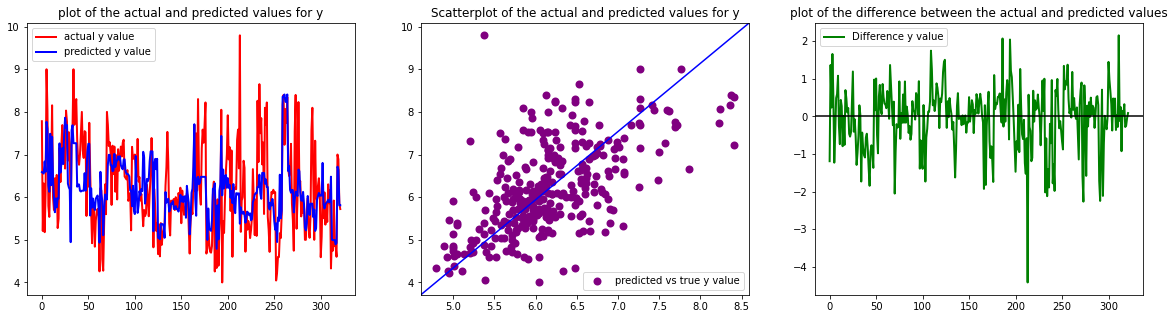

In [183]:
# Select knn, rf or svr
model_selection('knn', training_dataset, testing_dataset)